# Polyhedral Compiler Hands-on with Caten


This tutorial demonstrates how to use `caten.polyhedral` to construct and transform schedules for high-performance kernels, including Matrix Multiplication optimization and Conv-Pool Fusion.


## 1. Setup


In [1]:
import sys
sys.path.append("../")

import caten.isl as I
import caten.polyhedral as P
from caten.polyhedral.viz import viz_schedule, viz_ast

print("Caten initialized.")

Caten initialized.


## 2. Gemm

In [4]:
def create_gemm_schedule():
    A, B, C = map(I.expr, ("A", "B", "C"))
    zero = I.expr(0)

    with P.parameter("M, N, K"):
        s1 = P.domain("{ S_gemm_init[i,j] : 0<=i<M and 0<=j<N }")
        s2 = P.domain("{ S_gemm[i,j,k] : 0<=i<M and 0<=j<N and 0<=k<K }")
        with (s1|s2) as gemm:
            with P.filter("{ S_gemm_init[i,j] }"):
                with P.band("{ S_gemm_init[i,j] -> [j, i, 0] }"):
                    P.stmt("C[j,i] = 0")[lambda i, j: C[j, i].assign(zero)]
            with P.filter("{ S_gemm[i,j,k] }"):
                with P.band("{ S_gemm[i,j,k] -> [j, i, 1, k] }"):
                    P.stmt("C[j,i] = C[j,i], A[k,i], B[j,k]")[
                        lambda i, j, k: C[j, i].assign(C[j, i] + A[k, i] * B[j, k])
                    ]

    return gemm
print(create_gemm_schedule())

ScheduleNodeDomain(
ScheduleNodeDomain(
    ┏ [domain] (M, N, K)
    ┃  S_gemm[i, j, k]   : 0 ≤ i < M ∧ 0 ≤ j < N ∧ 0 ≤ k < K
    ┗  S_gemm_init[i, j] : 0 ≤ i < M ∧ 0 ≤ j < N
      ┗ [sequence]
        ┏ [filter]
        ┗  S_gemm_init[i, j]
          ┏ [band]
          ┃  S_gemm_init[i, j] → j
          ┃  S_gemm_init[i, j] → i
          ┗  S_gemm_init[i, j] → 0
            ┗ [leaf]
        ┏ [filter]
        ┗  S_gemm[i, j, k]
          ┏ [band]
          ┃  S_gemm[i, j, k] → j
          ┃  S_gemm[i, j, k] → i
          ┃  S_gemm[i, j, k] → 1
          ┗  S_gemm[i, j, k] → k
            ┗ [leaf]
)
)


## 3. Conv2D+Pool2D On-the-fly reduction

Conv2D

Pool2D

In [3]:
def create_conv_schedule():
    out, inp, wei = map(I.expr, ("Out", "In", "W"))
    zero = I.expr(0)
    with P.parameter("N, K_out, H_out, W_out, Cin, KH, KW"):
        d1 = P.domain("{ S_conv_init[n,k,h,w] : 0<=n<N and 0<=k<K_out and 0<=h<H_out and 0<=w<W_out }")
        d2 = P.domain("{ S_conv[n,k,h,w,c,kh,kw] : "
                     "0<=n<N and 0<=k<K_out and 0<=h<H_out and 0<=w<W_out and "
                     "0<=c<Cin and 0<=kh<KH and 0<=kw<KW }")

        with (d1 | d2) as conv:
            with P.filter("{ S_conv_init[n,k,h,w] }"):
                with P.band("{ S_conv_init[n,k,h,w] -> [n, k, h, w] }"):
                    P.stmt("Out[n,k,h,w] = 0")[lambda n, k, h, w: out[n, k, h, w].assign(zero)]
            with P.filter("{ S_conv[n,k,h,w,c,kh,kw] }"):
                with P.band("{ S_conv[n,k,h,w,c,kh,kw] -> [n, k, h, w, c, kh, kw] }"):
                    P.stmt("Out[n,k,h,w] = Out[n,k,h,w], In[n,c,h+kh,w+kw], W[k,c,kh,kw]")[
                        lambda n, k, h, w, c, kh, kw: out[n, k, h, w].assign(out[n, k, h, w] + inp[n, c, h + kh, w + kw] * wei[k, c, kh, kw])]
    return conv

def create_pool_schedule():
    S_pool = I.expr(2)
    with P.parameter("N, K_out, H_pool, W_pool, KH_pool, KW_pool, H_out, W_out"):
        pool_buf, out = I.expr("PoolBuf"), I.expr("Out")
        dom_str = "{ S_pool[n, k, h, w, rh, rw] : 0<=n<N and 0<=k<K_out and 0<=h<H_pool and 0<=w<W_pool and 0<=rh<KH_pool and 0<=rw<KW_pool }"
        with P.domain(dom_str) as pool:
            with P.band("{ S_pool[n, k, h, w, rh, rw] -> [n, k, h, w, rh, rw] }"):
                # Use f-string for stride in access map
                P.stmt(f"PoolBuf[n, k, h, w] = PoolBuf[n, k, h, w], Out[n, k, h*2 + rh, w*2 + rw]")[
                    lambda n, k, h, w, rh, rw: pool_buf[n, k, h, w].assign(
                        pool_buf[n, k, h, w].max(out[n, k, h * S_pool + rh, w * S_pool + rw]))]
    return pool

ScheduleNodeDomain(
ScheduleNodeDomain(
    ┏ [domain] (N, K_out, H_out, W_out, Cin, KH, KW)
    ┃  S_conv[n, k, h, w, c, kh, kw] : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h < H_out ∧ 0 ≤ w < W_out ∧ 0 ≤ c < Cin ∧ 0 ≤ kh < KH ∧ 0 ≤ kw < KW
    ┗  S_conv_init[n, k, h, w] : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h < H_out ∧ 0 ≤ w < W_out
      ┗ [sequence]
        ┏ [filter]
        ┗  S_conv_init[n, k, h, w]
          ┏ [band]
          ┃  S_conv_init[n, k, h, w] → n
          ┃  S_conv_init[n, k, h, w] → k
          ┃  S_conv_init[n, k, h, w] → h
          ┗  S_conv_init[n, k, h, w] → w
            ┗ [leaf]
        ┏ [filter]
        ┗  S_conv[n, k, h, w, c, kh, kw]
          ┏ [band]
          ┃  S_conv[n, k, h, w, c, kh, kw] → n
          ┃  S_conv[n, k, h, w, c, kh, kw] → k
          ┃  S_conv[n, k, h, w, c, kh, kw] → h
          ┃  S_conv[n, k, h, w, c, kh, kw] → w
          ┃  S_conv[n, k, h, w, c, kh, kw] → c
          ┃  S_conv[n, k, h, w, c, kh, kw] → kh
          ┗  S_conv[n, k, h, w, c, kh,

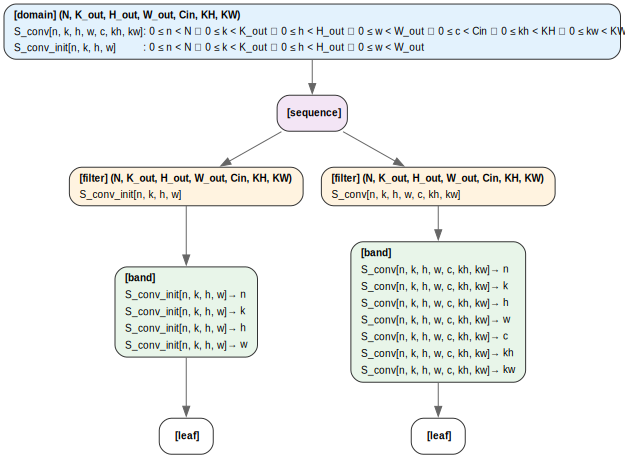

In [6]:
from caten.polyhedral.viz import viz_schedule, viz_ast
print(create_conv_schedule())
print(create_pool_schedule().to_c())
viz_schedule(create_conv_schedule())

In [15]:
with P.sequence(conv, pool) as seq:
    # todo: get reshape/permute parameter from conv/pool access rel
    with seq[0].permute(0, 1, 2, 3) as conv_band:
        pass
    with (seq[1] @ [1, 1, 4, 1]).permute(0, 1, 2, 3) as pool_band:
        pass
    seq = seq.fuse()
    # coalesce
    with (seq << P.Parallel()) as inner:
        tensor_core = (inner @ P.TensorCore(4, 4))

# conv+pool fusion and optimization
with (conv + pool) as sequence:
    # any idea?

# matmul
gemm = gemm_kernel()
with (gemm.permute("ijk -> ikj")).maximize_band_depth() as gemm:
    gemm_128x128x128 = gemm @ P.Parallel(128, 128, 128)
    gemm_64x64x128 = gemm << P.Prefetch(64, 64) # this will sunk, e.g.: mapped w/ pack_block_A, pack_block_B
    with (gemm @ P.TensorCore(8, 8, 8)) as gemm_tc, gemm_reminder:
        gemm_tc
        with (gemm_reminder @ P.Vectorize(8, 8)) as gemm_vec, gemm_rem:
            gemm_vec
        
print(gemm) # baseline
print(gemm_8x8x8) # optimized ver

# softmax
softmax = softmax_kernel()
with softmax @ P.Parallel(Local1, Local2) as ...:
    # any idea?
    pass

IndentationError: expected an indented block after 'with' statement on line 13 (1333366227.py, line 17)

In [5]:
ScheduleNodeDomain(
    ┏ [domain] (N, K_out, H_out, W_out, Cin, KH, KW)
    ┗ S_conv[n, k, h, w, c, kh, kw] : 0 ≤ n < N ∧ 0 ≤ k < K_out ∧ 0 ≤ h < H_out ∧ 0 ≤ w < W_out ∧ 0 ≤ c < Cin ∧ 0 ≤ kh < KH ∧ 0 ≤ kw < KW
      ┏ [band]
      ┃  S_conv[n, k, h, w, c, kh, kw] → n
      ┃  S_conv[n, k, h, w, c, kh, kw] → k
      ┃  S_conv[n, k, h, w, c, kh, kw] → h
      ┃  S_conv[n, k, h, w, c, kh, kw] → w
      ┃  S_conv[n, k, h, w, c, kh, kw] → c
      ┃  S_conv[n, k, h, w, c, kh, kw] → kh
      ┗  S_conv[n, k, h, w, c, kh, kw] → kw
        ┗ [leaf]
)

SyntaxError: invalid character '┏' (U+250F) (339859538.py, line 2)

 ## Softmax Optimization